In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

intron_annot = pd.read_csv('../data/IntronAnnotationsFromYang.Updated.tsv.gz', sep='\t')



In [2]:
def process_junc_file(sample, intron_annot):
    gm = pd.read_csv('../code/LongReads/Junctions/{sample}.junc.gz'.format(sample=sample), sep='\t', 
                  names = ['chrom', 'start', 'end', 'junction_id', 'read', 'strand'])
    
    gm = gm.merge(intron_annot, left_on=['chrom', 'start', 'end', 'strand'],
          right_on=['chrom', 'start', 'end', 'strand'])

    gm['junction_id'] = gm.chrom + ':' + gm.start.astype(str) + '-' + gm.end.astype(str) + ':' + gm.strand
    
    
    NMD_annot = ['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene']
    pc_annot = ['AnnotatedJunc_ProductiveCodingGene', 'AnnotatedJunc_ProductiveCodingGene']
    coding_gene = NMD_annot + pc_annot
    gm['intron_count'] = [1]*len(gm)
    gm['isNMD'] = gm.SuperAnnotation.isin(NMD_annot)
    gm['isPC'] = gm.SuperAnnotation.isin(pc_annot)
    gm['isCodingGene'] = gm.SuperAnnotation.isin(coding_gene)
    
    gm_by_read = gm.loc[gm.isCodingGene].groupby('read')[['intron_count', 'isPC', 'isNMD']].sum()
    
    sample_gm_array = sample_gm(gm_by_read)
    
    sample_gm_array = np.array(sample_gm_array)*100
    
    return gm, gm_by_read, sample_gm_array

def sample_row(row, k, times = 100):
    intron_count = int(row.intron_count)
    nmd_count = int(row.isNMD)
    
    if nmd_count == 0:
        nmd_sample_avg = 0
        
    else:
    
        juncs_population = ([1]*nmd_count) + ([0]*intron_count)

        nmd_sample = []

        for i in range(times):
            sample = np.random.choice(juncs_population, k, replace=False).sum()

            is_nmd = sample > 0
            
            nmd_sample.append(is_nmd)

        nmd_sample_avg = np.mean(nmd_sample)
    
    return nmd_sample_avg
    

from tqdm import tqdm 
def sample_k(gm_by_read, k):
    nmd_mean = []
    for i in range(k, 16):
        for idx, row in gm_by_read.loc[gm_by_read.intron_count == i].iterrows():
            nmd_mean.append(np.mean(sample_row(row, k)))
    return np.mean(nmd_mean)

def sample_gm(gm_by_read):
    k_list = []
    for k in tqdm(range(1, 15)):
        k_list.append(sample_k(gm_by_read, k))
        
    return k_list

In [3]:
ctrl1, ctrl1_by_read, sample_ctrl1 = process_junc_file('CTRL1_shRNA.SAMEA8691110', intron_annot)
ctrl2, ctrl2_by_read, sample_ctrl2 = process_junc_file('CTRL2_shRNA.SAMEA8691111', intron_annot)
kdNMD, kdNMD_by_read, sample_kdNMD = process_junc_file('SMG6_SMG7_shRNA.SAMEA8691113', intron_annot)

chRNA1, chRNA1_by_read, sample_chRNA1 = process_junc_file('K562_4sUchr_ONT_1.SAMN10505969', intron_annot)
chRNA2, chRNA2_by_read, sample_chRNA2 = process_junc_file('K562_4sUchr_ONT_2.SAMN10505968', intron_annot)
chRNA3, chRNA3_by_read, sample_chRNA3 = process_junc_file('K562_4sUchr_ONT_3.SAMN10505967', intron_annot)
chRNA4, chRNA4_by_read, sample_chRNA4 = process_junc_file('K562_4sUchr_ONT_4.SAMN12726878', intron_annot)
chRNA5, chRNA5_by_read, sample_chRNA5 = process_junc_file('K562_4sUchr_ONT_5a.SAMN12726877', intron_annot)
chRNA5b, chRNA5b_by_read, sample_chRNA5b = process_junc_file('K562_4sUchr_ONT_5b.SAMN12726876', intron_annot)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:13<00:00,  1.06it/s]


In [4]:
chRNA1.loc[chRNA1.isCodingGene].groupby('read').intron_count.sum().shape[0]

7780

In [5]:
chRNA2.loc[chRNA2.isCodingGene].groupby('read').intron_count.sum().shape[0]

3882

In [6]:
chRNA3.loc[chRNA3.isCodingGene].groupby('read').intron_count.sum().shape[0]

30319

In [7]:
chRNA4.loc[chRNA4.isCodingGene].groupby('read').intron_count.sum().shape[0]

41706

In [8]:
chRNA5.loc[chRNA5.isCodingGene].groupby('read').intron_count.sum().shape[0]

19188

In [9]:
chRNA5b.loc[chRNA5b.isCodingGene].groupby('read').intron_count.sum().shape[0]

19018

In [10]:
# sample_chRNA3 = np.array(sample_chRNA3)*100
# sample_chRNA4 = np.array(sample_chRNA4)*100
# sample_chRNA5 = np.array(sample_chRNA5)*100
# sample_chRNA5b = np.array(sample_chRNA5b)*100

# sample_kdNMD = np.array(sample_kdNMD)*100

# sample_ctrl1 = np.array(sample_ctrl1)*100
# sample_ctrl2 = np.array(sample_ctrl2)*100

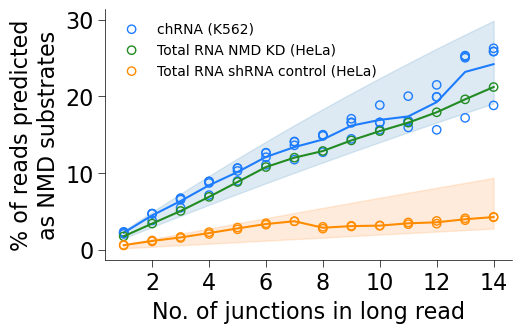

In [11]:
from scipy.stats import binom

figsize = (5.25, 3.25)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize, gridspec_kw={'hspace': 0.2})

ax.scatter(range(1, 15), sample_chRNA3, edgecolor='#1e7cff', facecolor="None", label ='chRNA (K562)', zorder=2)
ax.scatter(range(1, 15), sample_chRNA4, edgecolor='#1e7cff', facecolor="None", zorder=2)
ax.scatter(range(1, 15), sample_chRNA5, edgecolor='#1e7cff', facecolor="None", zorder=2)
ax.scatter(range(1, 15), sample_chRNA5b, edgecolor='#1e7cff', facecolor="None", zorder=2)

chRNA_median = [np.mean([sample_chRNA3[i], sample_chRNA4[i], sample_chRNA5[i], sample_chRNA5b[i]]) for i in range(14)]

ax.plot(range(1, 15), chRNA_median, c='#1e7cff')

ax.scatter(range(1, 15), sample_kdNMD, edgecolor='forestgreen', facecolor="None", label ='Total RNA NMD KD (HeLa)', zorder=2)
ax.plot(range(1, 15), sample_kdNMD, c='forestgreen', zorder=2)

ax.scatter(range(1, 15), sample_ctrl1, edgecolor='darkorange', facecolor="None", zorder=2, 
           label='Total RNA shRNA control (HeLa)')
ax.scatter(range(1, 15), sample_ctrl2, edgecolor='darkorange', facecolor="None", zorder=2)

ctrl_median = [np.mean([sample_ctrl1[i], sample_ctrl2[i]]) for i in range(14)]

ax.plot(range(1, 15), ctrl_median, c='darkorange', zorder=2)

x = np.arange(1, 15)


ax.fill_between(range(1, 15), 100*(1-binom.pmf(0, x, 0.015)), 100*(1-binom.pmf(0, x, 0.025)), color='tab:blue', 
                alpha=0.15, zorder=1)

ax.fill_between(range(1, 15), 100*(1-binom.pmf(0, x, 0.002)), 100*(1-binom.pmf(0, x, 0.007)), color='tab:orange', 
                alpha=0.15, zorder=1)

ax.legend(frameon=False,fontsize=10)


ax.set_ylabel('% of reads predicted\nas NMD substrates', size=16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.set_xticks([2, 4, 6, 8, 10, 12, 14])
ax.tick_params(labelsize=16, size=5, width=0.5)

ax.set_xlabel('No. of junctions in long read', size=16)

plt.savefig('../code/manuscript_plots/Fig1F.ont.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../code/manuscript_plots/Fig1F.ont.png', dpi=300, bbox_inches='tight')

In [12]:
gm1, gm1_by_read, sample_gm1 = process_junc_file('GM1', intron_annot)
gm2, gm2_by_read, sample_gm2 = process_junc_file('GM2', intron_annot)
gm3, gm3_by_read, sample_gm3 = process_junc_file('GM3', intron_annot)
gm4, gm4_by_read, sample_gm4 = process_junc_file('GM4', intron_annot)
gm5, gm5_by_read, sample_gm5 = process_junc_file('GM5', intron_annot)
gm6, gm6_by_read, sample_gm6 = process_junc_file('GM6', intron_annot)
gm7, gm7_by_read, sample_gm7 = process_junc_file('GM7', intron_annot)
gm8, gm8_by_read, sample_gm8 = process_junc_file('GM8', intron_annot)
gm9, gm9_by_read, sample_gm9 = process_junc_file('GM9', intron_annot)
gm10, gm10_by_read, sample_gm10 = process_junc_file('GM10', intron_annot)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [01:47<00:00,  7.70s/it]


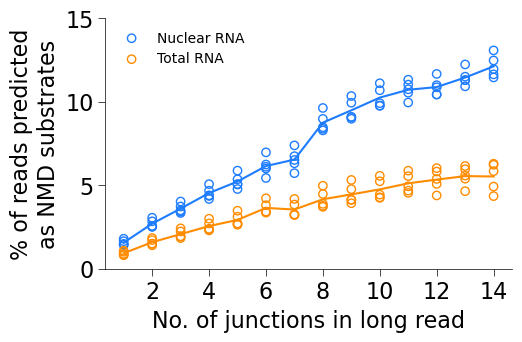

In [19]:
from scipy.stats import binom

figsize = (5.25, 3.25)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize, gridspec_kw={'hspace': 0.2})


ax.scatter(range(1, 15), sample_gm1, edgecolor='#1e7cff', facecolor="None", label ='Nuclear RNA', zorder=2)
ax.scatter(range(1, 15), sample_gm3, edgecolor='#1e7cff', facecolor="None", zorder=2)
ax.scatter(range(1, 15), sample_gm5, edgecolor='#1e7cff', facecolor="None", zorder=2)
ax.scatter(range(1, 15), sample_gm7, edgecolor='#1e7cff', facecolor="None", zorder=2)
ax.scatter(range(1, 15), sample_gm9, edgecolor='#1e7cff', facecolor="None", zorder=2)

nuclear_median = [np.mean([sample_gm1[i], sample_gm3[i], sample_gm5[i], sample_gm7[i], sample_gm9[i]]) for i in range(14)]
ax.plot(range(1, 15), nuclear_median, c='#1e7cff')

ax.scatter(range(1, 15), sample_gm2, edgecolor='darkorange', facecolor="None", label ='Total RNA', zorder=2)
ax.scatter(range(1, 15), sample_gm4, edgecolor='darkorange', facecolor="None", zorder=2)
ax.scatter(range(1, 15), sample_gm6, edgecolor='darkorange', facecolor="None", zorder=2)
ax.scatter(range(1, 15), sample_gm8, edgecolor='darkorange', facecolor="None", zorder=2)
ax.scatter(range(1, 15), sample_gm10, edgecolor='darkorange', facecolor="None", zorder=2)

total_median = [np.mean([sample_gm2[i], sample_gm4[i], sample_gm6[i], sample_gm8[i], sample_gm10[i]]) for i in range(14)]
ax.plot(range(1, 15), total_median, c='darkorange')

x = np.arange(1, 15)

ax.legend(frameon=False,fontsize=10)


ax.set_ylabel('% of reads predicted\nas NMD substrates', size=16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.set_xticks([2, 4, 6, 8, 10, 12, 14])
ax.set_yticks([0, 5, 10, 15])
ax.tick_params(labelsize=16, size=5, width=0.5)

ax.set_xlabel('No. of junctions in long read', size=16)

plt.savefig('../code/manuscript_plots/SuppFig1F.isoseq.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/SuppFig1F.isoseq.png', dpi=300, bbox_inches='tight',)

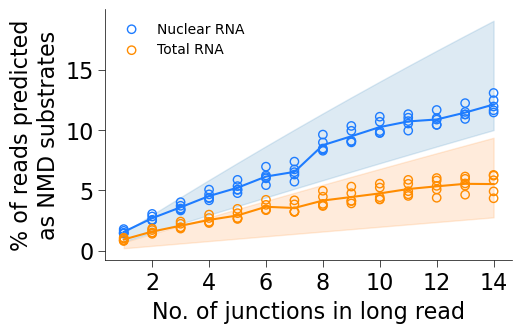

In [20]:
from scipy.stats import binom

figsize = (5.25, 3.25)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize, gridspec_kw={'hspace': 0.2})


ax.scatter(range(1, 15), sample_gm1, edgecolor='#1e7cff', facecolor="None", label ='Nuclear RNA', zorder=2)
ax.scatter(range(1, 15), sample_gm3, edgecolor='#1e7cff', facecolor="None", zorder=2)
ax.scatter(range(1, 15), sample_gm5, edgecolor='#1e7cff', facecolor="None", zorder=2)
ax.scatter(range(1, 15), sample_gm7, edgecolor='#1e7cff', facecolor="None", zorder=2)
ax.scatter(range(1, 15), sample_gm9, edgecolor='#1e7cff', facecolor="None", zorder=2)

nuclear_median = [np.mean([sample_gm1[i], sample_gm3[i], sample_gm5[i], sample_gm7[i], sample_gm9[i]]) for i in range(14)]
ax.plot(range(1, 15), nuclear_median, c='#1e7cff')

ax.scatter(range(1, 15), sample_gm2, edgecolor='darkorange', facecolor="None", label ='Total RNA', zorder=2)
ax.scatter(range(1, 15), sample_gm4, edgecolor='darkorange', facecolor="None", zorder=2)
ax.scatter(range(1, 15), sample_gm6, edgecolor='darkorange', facecolor="None", zorder=2)
ax.scatter(range(1, 15), sample_gm8, edgecolor='darkorange', facecolor="None", zorder=2)
ax.scatter(range(1, 15), sample_gm10, edgecolor='darkorange', facecolor="None", zorder=2)

total_median = [np.mean([sample_gm2[i], sample_gm4[i], sample_gm6[i], sample_gm8[i], sample_gm10[i]]) for i in range(14)]
ax.plot(range(1, 15), total_median, c='darkorange')

x = np.arange(1, 15)

ax.legend(frameon=False,fontsize=10, loc = 'upper left')


ax.set_ylabel('% of reads predicted\nas NMD substrates', size=16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.set_xticks([2, 4, 6, 8, 10, 12, 14])
ax.set_yticks([0, 5, 10, 15])
ax.tick_params(labelsize=16, size=5, width=0.5)

ax.set_xlabel('No. of junctions in long read', size=16)

ax.fill_between(range(1, 15), 100*(1-binom.pmf(0, x, 0.0075)), 100*(1-binom.pmf(0, x, 0.015)), color='tab:blue', 
                alpha=0.15, zorder=1)

ax.fill_between(range(1, 15), 100*(1-binom.pmf(0, x, 0.002)), 100*(1-binom.pmf(0, x, 0.007)), color='tab:orange', 
                alpha=0.15, zorder=1)

plt.savefig('../code/manuscript_plots/SuppFig1F.isoseq.shade.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/SuppFig1F.isoseq.shade.png', dpi=300, bbox_inches='tight',)